In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

In [ ]:
df = pd.read_csv('engagement_score_active.csv', parse_dates=['month'])

eng = df['engagement_score']

median = eng.median()
mean   = eng.mean()
std    = eng.std()

near_zero_prop = (eng < 0.05).mean()
high_tail_prop = (eng > 0.8).mean()

print("Total observations: ", len(eng))
print(f"Median engagement:     {median:.2f}")
print(f"Mean engagement:       {mean:.2f}")
print(f"Std. deviation:        {std:.2f}")
print(f"Proportion near zero:  {near_zero_prop:.1%}")
print(f"High-intensity tail:   {high_tail_prop:.1%}")


Total observations:  1195
Median engagement:     0.37
Mean engagement:       0.40
Std. deviation:        0.25
Proportion near zero:  8.2%
High‐intensity tail:   8.5%


In [ ]:
df = pd.read_csv('engagement_score_average.csv', parse_dates=['month'])

eng = df['engagement_score']

median = eng.median()
mean   = eng.mean()
std    = eng.std()

near_zero_prop = (eng < 0.05).mean()
high_tail_prop = (eng > 0.8).mean()

print("Total observations: ", len(eng))
print(f"Median engagement:     {median:.2f}")
print(f"Mean engagement:       {mean:.2f}")
print(f"Std. deviation:        {std:.2f}")
print(f"Proportion near zero:  {near_zero_prop:.1%}")
print(f"High‐intensity tail:   {high_tail_prop:.1%}")


Total observations:  819
Median engagement:     0.43
Mean engagement:       0.43
Std. deviation:        0.29
Proportion near zero:  9.8%
High‐intensity tail:   13.6%


Average set: slope = -0.00008, R² = 0.000
Active set: slope = 0.00003, R² = 0.000


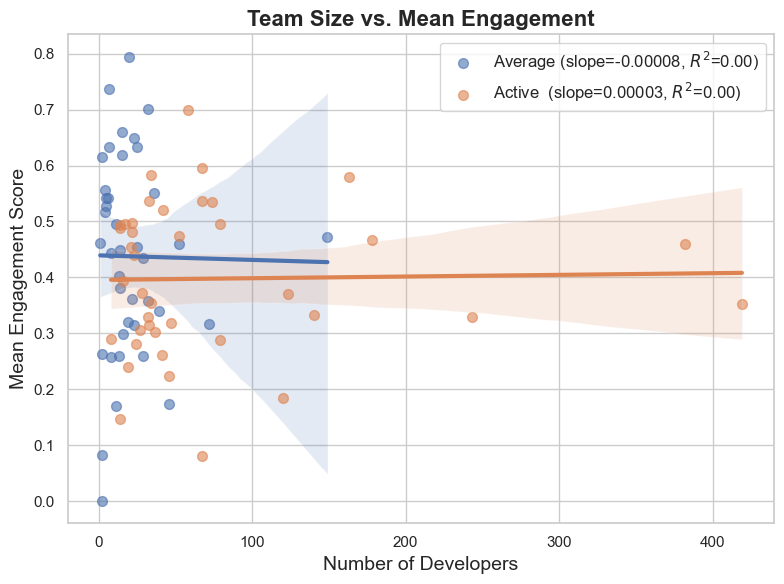

In [6]:
eng_avg = pd.read_csv('engagement_score_average.csv', parse_dates=['month'])
comm_avg = pd.read_csv('commit_data_average.csv',   parse_dates=['commit_date'])
comm_avg['month'] = comm_avg['commit_date'].dt.to_period('M').dt.to_timestamp()

roster_avg = (
    comm_avg
    .groupby('url')['developer']
    .nunique()
    .reset_index(name='num_developers')
)
medavg = (
    eng_avg
    .groupby('url')['engagement_score']
    .mean()
    .reset_index(name='mean_engagement')
)
summary_avg = pd.merge(roster_avg, medavg, on='url')

eng_act = pd.read_csv('engagement_score_active.csv', parse_dates=['month'])
comm_act = pd.read_csv('commit_data_active.csv',   parse_dates=['commit_date'])
comm_act['month'] = comm_act['commit_date'].dt.to_period('M').dt.to_timestamp()

roster_act = (
    comm_act
    .groupby('url')['developer']
    .nunique()
    .reset_index(name='num_developers')
)
medact = (
    eng_act
    .groupby('url')['engagement_score']
    .mean()
    .reset_index(name='mean_engagement')
)
summary_act = pd.merge(roster_act, medact, on='url')

def fit_report(df, label):
    X = df[['num_developers']].values
    y = df['mean_engagement'].values
    m = LinearRegression().fit(X, y)
    slope, r2 = m.coef_[0], m.score(X, y)
    print(f"{label}: slope = {slope:.5f}, R² = {r2:.3f}")
    return slope, r2

slope_avg, r2_avg = fit_report(summary_avg, "Average set")
slope_act, r2_act = fit_report(summary_act, "Active set")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))

ax = sns.regplot(
    data=summary_avg, x='num_developers', y='mean_engagement',
    scatter_kws={'alpha':0.6,'s':50,'color':'C0'},
    line_kws   ={'color':'C0','linewidth':3},
    label       =f"Average (slope={slope_avg:.5f}, $R^2$={r2_avg:.2f})"
)

sns.regplot(
    data=summary_act, x='num_developers', y='mean_engagement',
    scatter_kws={'alpha':0.6,'s':50,'color':'C1'},
    line_kws   ={'color':'C1','linewidth':3},
    label       =f"Active  (slope={slope_act:.5f}, $R^2$={r2_act:.2f})",
    ax=ax
)

ax.set_title('Team Size vs. Mean Engagement', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Developers', fontsize=14)
ax.set_ylabel('Mean Engagement Score', fontsize=14)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()


/Users/yasir/Documents/VU/SIG/.venv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/yasir/Documents/VU/SIG/.venv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/yasir/Documents/VU/SIG/.venv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


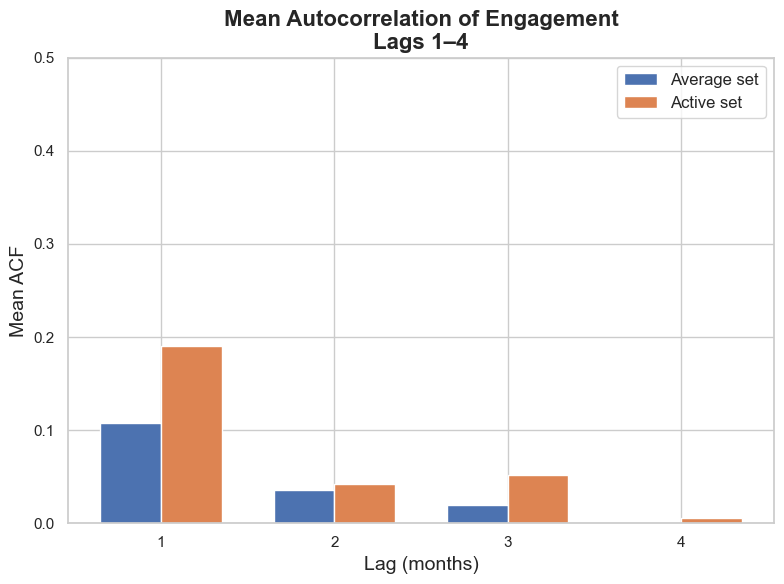

In [ ]:
eng_avg = pd.read_csv('engagement_score_average.csv', parse_dates=['month'])
eng_act = pd.read_csv('engagement_score_active.csv',  parse_dates=['month'])

def mean_acf(df, url_col='url', score_col='engagement_score', max_lag=4):
    acf_means = []
    for lag in range(1, max_lag + 1):
        vals = []
        for project, grp in df.groupby(url_col):
            ser = grp.sort_values('month')[score_col]
            if len(ser) > lag:
                vals.append(ser.autocorr(lag))
        acf_means.append(np.nanmean(vals))
    return np.array(acf_means)

lags       = 4
acf_avg    = mean_acf(eng_avg,    max_lag=lags)
acf_active = mean_acf(eng_act,    max_lag=lags)

sns.set_theme(style="whitegrid")
x = np.arange(1, lags+1)
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x - width/2, acf_avg,    width, label='Average set', color='C0')
ax.bar(x + width/2, acf_active, width, label='Active set',  color='C1')

ax.set_title('Mean Autocorrelation of Engagement\nLags 1-4', fontsize=16, fontweight='bold')
ax.set_xlabel('Lag (months)', fontsize=14)
ax.set_ylabel('Mean ACF',       fontsize=14)
ax.set_xticks(x)
ax.set_ylim(0, 0.5)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

def missing_summary(path, label):
    df = pd.read_csv(path)
    cols = ['dmm_unit_size', 'dmm_unit_complexity', 'dmm_unit_interfacing']
    miss_pct = df[cols].isna().mean().rename(lambda c: f"{c}_missing_pct")
    return miss_pct.to_frame(label)

paths = {
    'Active set' : 'commit_data_active.csv',
    'Average set': 'commit_data_average.csv'
}

summary = pd.concat(
    [missing_summary(path, label) for label, path in paths.items()],
    axis=1
)

summary = summary * 100
summary.index = summary.index.str.replace('_missing_pct', '')
print(summary.round(2))


                      Active set  Average set
dmm_unit_size              70.47        74.36
dmm_unit_complexity        70.39        74.25
dmm_unit_interfacing       70.48        74.40


In [23]:
eng = pd.read_csv('engagement_score_active.csv', parse_dates=['month'])
comm = pd.read_csv('commit_data_active.csv', parse_dates=['commit_date'])
comm['month'] = comm['commit_date'].dt.to_period('M').dt.to_timestamp()

roster = comm.groupby('url')['developer'].nunique().reset_index(name='num_developers')
median_eng = eng.groupby('url')['engagement_score'] \
                .median().reset_index(name='median_engagement')

summary = pd.merge(roster, median_eng, on='url')

X = summary[['num_developers']].values
y = summary['median_engagement'].values
model = LinearRegression().fit(X, y)
slope = model.coef_[0]
r2 = model.score(X, y)

max_lag = 4
acf_vals = []
for lag in range(1, max_lag + 1):
    vals = []
    for project in eng['url'].unique():
        series = eng[eng['url'] == project].sort_values('month')['engagement_score']
        if len(series) > lag:
            vals.append(series.autocorr(lag))
    acf_vals.append(np.nanmean(vals))

results = pd.DataFrame({
    'Metric': ['Trend slope', 'Trend R²'] + [f'Lag {lag} ACF' for lag in range(1, max_lag+1)],
    'Value': [round(slope, 4), round(r2, 3)] + [round(val, 3) for val in acf_vals]
})

import pprint
pprint.pprint(results.to_dict('records'))


[{'Metric': 'Trend slope', 'Value': 0.0001},
 {'Metric': 'Trend R²', 'Value': 0.001},
 {'Metric': 'Lag 1 ACF', 'Value': 0.19},
 {'Metric': 'Lag 2 ACF', 'Value': 0.042},
 {'Metric': 'Lag 3 ACF', 'Value': 0.052},
 {'Metric': 'Lag 4 ACF', 'Value': 0.005}]


Weighted Engagement vs. Final Cumulative DMM per project:

                                                               url  weighted_engagement  final_cumulative_dmm
                                    https://github.com/AdaCore/gps             0.747608              0.208155
                                https://github.com/AdaCore/langkit             0.763315              0.356081
                      https://github.com/AirenSoft/OvenMediaEngine             0.509933              0.374222
                              https://github.com/Automattic/themes             0.545173              0.345302
                    https://github.com/AxonFramework/AxonFramework             0.673345              0.206619
                                https://github.com/Azure/azure-cli             0.457108              0.410600
                         https://github.com/Azure/azure-powershell             0.593330              0.184681
                            https://github.com/BlackArch/blac

/var/folders/9b/xhp09f3d7xn_fpzfk4sg3pj80000gn/T/ipykernel_61351/492119424.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eng


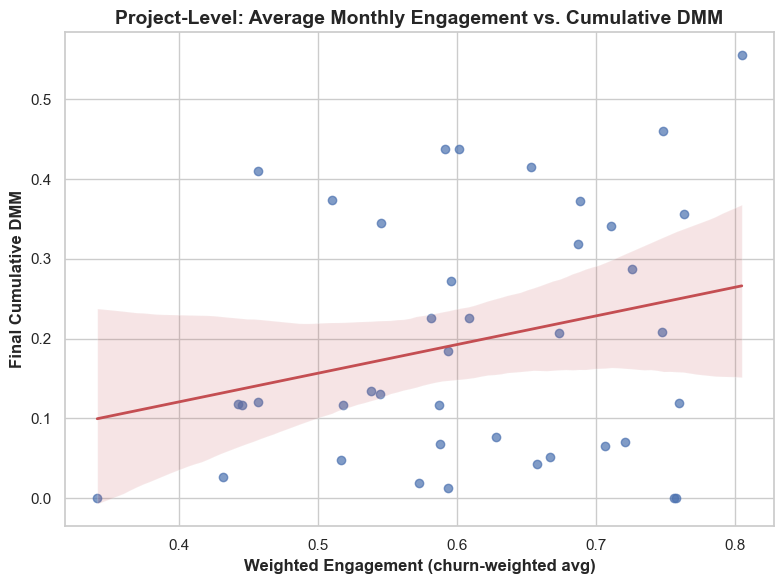

In [ ]:
eng = pd.read_csv('engagement_score_active.csv', parse_dates=['month'])
dmm = pd.read_csv('dmm_active.csv', parse_dates=['month'])

weighted_eng = (
    eng
    .groupby('url')
    .apply(lambda g: (g['engagement_score'] * g['churn_sum']).sum() / g['churn_sum'].sum())
    .reset_index(name='weighted_engagement')
)

final_dmm = (
    dmm.sort_values(['url','month'])
       .groupby('url')['dmm_cumulative_w']
       .last()
       .reset_index(name='final_cumulative_dmm')
)

summary = pd.merge(weighted_eng, final_dmm, on='url')

corr = summary['weighted_engagement'].corr(summary['final_cumulative_dmm'])

print("Weighted Engagement vs. Final Cumulative DMM per project:\n")
print(summary.to_string(index=False))
print(f"\nOverall Pearson correlation: {corr:.3f}\n")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))
sns.regplot(
    x='weighted_engagement',
    y='final_cumulative_dmm',
    data=summary,
    scatter_kws={'alpha':0.7},
    line_kws={'color':'C3','linewidth':2}
)
plt.xlabel('Weighted Engagement (churn-weighted avg)', fontsize=12, fontweight='bold')
plt.ylabel('Final Cumulative DMM', fontsize=12, fontweight='bold')
plt.title('Project-Level: Average Monthly Engagement vs Cumulative DMM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


/var/folders/9b/xhp09f3d7xn_fpzfk4sg3pj80000gn/T/ipykernel_61351/649684997.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(grp['engagement_score'], grp['dmm_monthly_w'])
/Users/yasir/Documents/VU/SIG/.venv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yasir/Documents/VU/SIG/.venv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


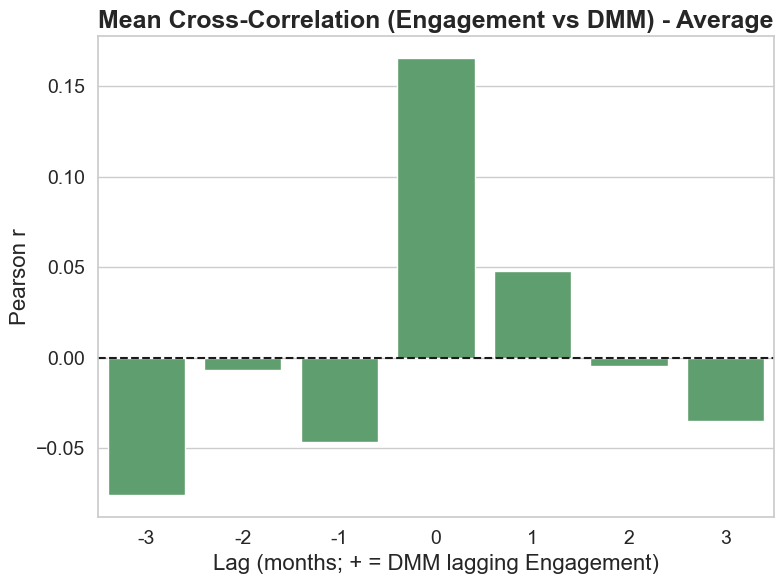

In [37]:
eng = pd.read_csv('engagement_score_average.csv', parse_dates=['month'])
dmm = pd.read_csv('dmm_average.csv',      parse_dates=['month'])
df = eng.merge(dmm, on=['url','month'], how='inner')

window = 6        # 6-month rolling
max_lag = 3       # 3 months cross-corr

roll_stats = []
xcorr_stats = {lag: [] for lag in range(-max_lag, max_lag+1)}
spearman_stats = []

for url, grp in df.groupby('url'):
    grp = grp.sort_values('month').set_index('month')
    if len(grp) < window: 
        continue

    r_roll = grp['engagement_score'].rolling(window).corr(grp['dmm_monthly_w'])
    roll_stats.append(r_roll.mean())

    rho, _ = spearmanr(grp['engagement_score'], grp['dmm_monthly_w'])
    spearman_stats.append(rho)

    for lag in range(-max_lag, max_lag+1):
        ser1 = grp['engagement_score']
        ser2 = grp['dmm_monthly_w'].shift(lag)
        valid = ser1.notna() & ser2.notna()
        if valid.sum() > window:
            xcorr_stats[lag].append(ser1[valid].corr(ser2[valid]))

lags = sorted(xcorr_stats)
mean_xcorr = [np.nanmean(xcorr_stats[lag]) for lag in lags]

plt.figure(figsize=(8,6))
sns.barplot(x=lags, y=mean_xcorr, color='C2')
plt.axhline(0, color='k', linestyle='--')
plt.title('Mean Cross-Correlation (Engagement vs DMM) - Average', fontsize=18, fontweight='bold')
plt.xlabel('Lag (months; + = DMM lagging Engagement)', fontsize=16)
plt.ylabel('Pearson r', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()
